Learn the inter-grid operator ratio for interface problems using multigrid framework, dataset is constructed by changing RHS 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import h5py
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class RHSDataSet(Dataset):
    def __init__(self, h5file, case='train', transform=None, target_transform=None):
        """
        case = 'train' or 'test'
        """
        h5 = h5py.File(h5file,'r')
        self.data = np.array(h5[case], dtype=np.float32)
        self.totensor = ToTensor()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        rhs_tensor = self.totensor(self.data[idx])
        if self.transform:
            rhs_tensor = self.transform(rhs_tensor)
        return rhs_tensor

In [3]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [4]:
def random_sampling(v):
    d1, d2, d3, d4 = v.shape
    for i in range(d1):
        for j in range(d2):
            coef = 10*np.random.rand(2) - 5
            v[i, j, :, :] = torch.from_numpy(coef[0]*np.random.random((d3,d4)) + coef[1])

In [5]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 20] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshHandler(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


In [9]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64):
        super(MultiGrid, self).__init__()

        # Hyper parameters
        self.m = 6 # number of iterations to compute q

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Inter-grid communication network models
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        restriction_kernel = torch.asarray([[1, 2, 1],
                                            [2, 4, 2],
                                            [1, 2, 1]], dtype=torch.float32) / 16.0
        self.conv.weight = nn.Parameter(restriction_kernel.reshape(1,1,3,3))
        self.conv.requires_grad_(False)

        self.deconv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        interpolation_kernel = torch.asarray([[1, 2, 1],
                                              [2, 4, 2],
                                              [1, 2, 1]], dtype=torch.float32) / 4.0
        interpolation_kernel = interpolation_kernel #+ torch.randn((3,3))
        self.deconv.weight = nn.Parameter(interpolation_kernel.reshape(1,1,3,3))
        # self.deconv.requires_grad_(True)
        self.deconv.requires_grad_(False)

        self.w = nn.Parameter(torch.asarray([4.,1.], dtype=torch.float32))
        self.w.requires_grad_(True)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def qm(self, x):
        "Compute the convergence factor after m iterations"
        res1 = self.f - self.grids[0].Knet(x)
        res0 = self.f - self.grids[0].Knet(self.v)
        return torch.mean(torch.pow(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/self.m))
    
    def forward(self, F):
        '''Input is RHS field F'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        random_sampling(self.v)
        U = torch.clone(self.v)
    
        for i in range(self.m-1):
            U = self.iterate(U).detach()
        return self.iterate(U)

    def iterate(self, x):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = self.f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            self.grids[j+1].f = self.w[0]*self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            error_delta = self.w[1]*self.Interpolate(self.grids[j+1].v)
            self.grids[j].v = self.grids[j].v + error_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [10]:
n = 2**4
model = MultiGrid(n)
rhs = next(iter(train_dataloader))

In [11]:
print(list(model.parameters()))

[Parameter containing:
tensor([4., 1.], requires_grad=True), Parameter containing:
tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]]), Parameter containing:
tensor([[[[0.2500, 0.5000, 0.2500],
          [0.5000, 1.0000, 0.5000],
          [0.2500, 0.5000, 0.2500]]]])]


0 0.06237572059035301
1 0.02288946881890297
2 0.008671721443533897
3 0.003244717139750719
4 0.0012120046885684133
5 0.0004553644102998078
6 0.0001727696944726631
7 6.644657696597278e-05
8 2.586844675533939e-05
Solution converges after 9 multi-grid iterations 


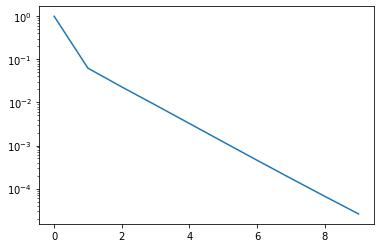

In [13]:
EPS = 5e-5
n_multigrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[10].unsqueeze(0))
err_occured = False
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [14]:
model_dir = 'Model/multigrid_rhs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.deconv.weight
model.w

Parameter containing:
tensor([4., 1.], requires_grad=True)

In [11]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_q = model.qm(u_out)
        
        loss_q.backward()
        optimizer.step()
        running_loss += loss_q.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [22]:
num_epoch = 100
best_vloss = 1_000_000.

qm_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_q = train_one_epoch()
    print(epoch, avg_q)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,'model_multigrid_interface_ratio.pth')
    torch.save(model.state_dict(), mpath)
    qm_train.append(avg_q)

print("\nNew value:")
model.conv.weight
model.deconv.weight
model.w

0 0.2247431119903922
1 0.2231322107836604
2 0.22280019428581
3 0.22826130036264658
4 0.22450554370880127
5 0.2260519778355956
6 0.22406656946986914
7 0.22443372756242752
8 0.2244200436398387
9 0.22220655903220177
10 0.22545632999390364
11 0.22494463808834553
12 0.22349247802048922
13 0.2270556502044201
14 0.2238521696999669
15 0.22476547304540873
16 0.22364880796521902
17 0.22711641993373632
18 0.2245461717247963
19 0.22569606266915798
20 0.22335275169461966
21 0.228502226062119
22 0.22591398283839226
23 0.22595532331615686
24 0.22530644852668047
25 0.2266649305820465
26 0.22639547940343618
27 0.22788951639086008
28 0.2251609181985259
29 0.22753821033984423
30 0.2238112948834896
31 0.228161983191967
32 0.22795624565333128
33 0.22849994339048862
34 0.2236491944640875
35 0.22842428367584944
36 0.22515413630753756
37 0.2283377619460225
38 0.22981642838567495
39 0.22585986368358135
40 0.2275564968585968
41 0.22618500515818596
42 0.22932825423777103
43 0.22551514115184546
44 0.2296437928453

Parameter containing:
tensor([4.2951, 0.9370], requires_grad=True)

Text(0.5, 0, 'epoch')

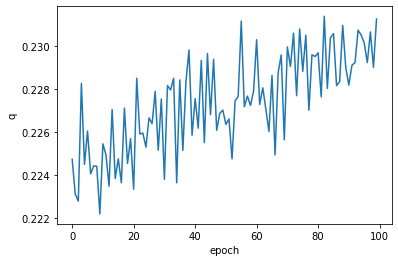

In [23]:
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [24]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,'model_multigrid_interface_ratio.pth')))
model.w

Parameter containing:
tensor([4.2951, 0.9370], requires_grad=True)

In [15]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 0.0761592760682106
1 0.019912810996174812
2 0.006012131925672293
3 0.0019053753931075335
4 0.000618059013504535
5 0.0002035615179920569
6 6.774195207981393e-05
7 2.26942738663638e-05
Solution converges after 8 multi-grid iterations 


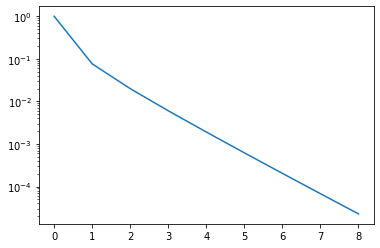

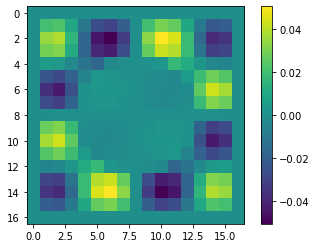

In [16]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [18]:
# Test the multigrid iteration
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w.detach()
        self.restrict_kernel = inter_model.conv.weight.detach()
        self.interpolate_kernel = inter_model.deconv.weight.detach()
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        f_res = f[:, :, 1:-1, 1:-1]
        f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        #f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        return F.pad(f_res,(1,1,1,1),"constant",0) # pad with zeros

    def Interpolate(self, v):
        '''
        Perform linear interpolation and upsample to previous level ==> Return size: (2*N - 1), Ex. 17 -> 33
        '''
        v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        #v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        return v

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return torch.linalg.norm(v.reshape(-1)-self.u_exact.reshape(-1), ord=torch.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].v = self.grids[l].Relax(v, f, n_sample)
        if(not self.grids[l].IsCoarsest()):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            self.grids[l+1].f = self.w[0]*self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.w[1]*self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].v = self.grids[l].Relax(self.grids[l].v,self.grids[l].f,n_sample) 

    def Solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.rec_V_cycle(0,self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.09180138260126114
0.028231458342136 0.030251162126660347
0.00877138498662918 0.012433032505214214
0.0032285981857128857 0.0055278572253882885
0.0013901009479226289 0.0025204727426171303
0.0006357373695377368 0.0011647288920357823
0.00029598654453148624 0.0005410999292507768
0.00013943754833960198 0.00025288789765909314
6.133568527932066e-05 0.00011775077291531488
2.882283588976016e-05 5.4840813390910625e-05
1.841801136747259e-05 2.7273083105683327e-05
Solution converges after 11 V-cycle iterations with relative error of 1.841801136747259e-05


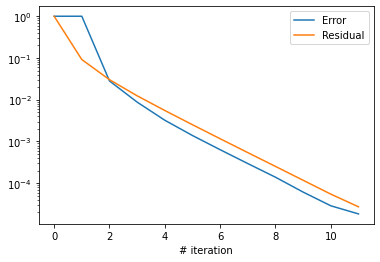

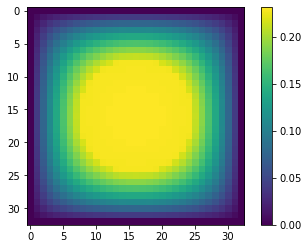

In [21]:
# Multigrid implementation
n = 2**5
prob_mg = Multigrid(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.Solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [22]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.563877453102131
